### Validation schema

In [1]:
# linear algebra
import numpy as np

#working with data in table structers
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt


# working with files
import sys
import os
from pathlib import Path
import csv
import io

# to off warnings
import warnings
warnings.filterwarnings('ignore')

# validation schema 
import time
import sklearn
from sklearn.model_selection import train_test_split
from datetime import timedelta, datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# metrics  calculation
from sklearn.metrics import (
    mean_squared_error as mse_lib, 
    mean_absolute_error as mae_lib,
    mean_absolute_percentage_error as mape_lib,
    r2_score as r2_lib
)
from permetrics.regression import RegressionMetric

# models
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
import catboost as cb

In [2]:
# # using ray engine for parallel calculation(for oprimization)
# %env MODIN_ENGINE=ray
# import modin.pandas as mpd

### Read data

In [3]:
%%time

# get directory path
dirpath = os.getcwd()

# set the data path
train_test_data_path = Path(dirpath) / 'data' / 'train_test_data'
print(train_test_data_path)
print(type(train_test_data_path))

# initiate dict for data
data = {}

# load data to dict
for file_path in train_test_data_path.iterdir():
    if file_path.is_file():
        data[file_path.stem] = pd.read_csv(file_path)
        print(file_path.stem)

C:\Repository\DS-Intership\data\train_test_data
<class 'pathlib.WindowsPath'>
submission_data
submission_example
train_data
CPU times: total: 15.7 s
Wall time: 16.2 s


### Validation schema creation

In [4]:
"""
    The following indexes will be used:
        
        from train_data:
          date_block_num
          shop_id
          item_category_id
          item_id
          item_cnt_month
        
        from test_data:
            shop_id',
            'item_id',
            'ID'

    Concept:
        Apply expanding window validation (except last month - target of competition)
        Monthly predictions
"""

class Validation:
    def __init__(self,
                 train_data,
                 submission_data,
                 submission_example,
                 metrics=['RMSE', 'MAE', 'MAPE', 'sMAPE', 'R2'],
                 n_splits=5,
                 model=RandomForestRegressor(max_depth=1, n_estimators=1, random_state=42, n_jobs=-1),
                 params=None,
                 check_nans = True,
                 dropna = False,
                 check_infs = True,
                 validation_schema_plot=False
                ):
        self.train_data = train_data
        self.submission_data = submission_data
        self.submission_example = submission_example
        self.metrics = metrics
        self.n_splits = n_splits
        self.model = model
        self.params = params
        self.tscv = TimeSeriesSplit(n_splits=self.n_splits)
    
        # Check data for valid columns
        assert set([
                    'date_block_num',
                    'shop_id',
                    'item_category_id',
                    'item_id',
                    'item_cnt_month'
                   ]).issubset(train_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_category_id',
                    'item_id',
                   ]).issubset(submission_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_id',
                    'ID'
                    ]).issubset(submission_example.columns),\
                "Invalid data"
        
        # Check for valid variables
        if dropna:
            self.train_data = self.train_data.dropna()
            self.submission_data = self.submission_data.dropna()
            
        if check_nans:
            assert self.train_data.isna().sum().sum() == 0, 'Train data have NaNs'
            assert self.submission_data.isna().sum().sum() == 0, 'Test data have NaNs'
        
        if check_infs:
            assert np.isfinite(self.train_data).sum().sum() != 0, 'Train data have Infs'
            assert np.isfinite(self.submission_data).sum().sum() != 0, 'Test data have Infs'    
        
        # Сheck for sorting by timeseries data
        amount_of_unsorted_rows = len(self.train_data) - (self.train_data.date_block_num.diff().fillna(0) >= 0).sum()
        if amount_of_unsorted_rows != 0:
            print(f"Data is not sorted by time ({amount_of_unsorted_rows} rows), it will be further sorted automatically")
            self.train_data = self.train_data.sort_values(by=['date_block_num'])
        
        # Validation process visualisation
        if validation_schema_plot:
            split_history = {
                'Step': ["Step "+str(i) for i in range(1, self.n_splits+1)],
                'Train Data': [], 
                'Validation Data': []
            }
            for train, val in self.tscv.split(self.train_data[['item_id', 'shop_id', 'item_cnt_month']]):    
                split_history['Train Data'].append(train.max()-train.min())
                split_history['Validation Data'].append(val.max()-val.min())
            df = pd.DataFrame(split_history)
            print(df)
            sns.set(style="whitegrid")
            plt.figure(figsize=(6, 5))
            sns.barplot(x='Step', y='Train Data', data=df, color='skyblue', label='Train Data')
            sns.barplot(x='Step', y='Validation Data', data=df, color='salmon', label='Validation Data', bottom=df['Train Data'])
            plt.title('Distribution of data for training and validation')
            plt.xlabel('Validation step')
            plt.ylabel('Data quantity')
            plt.legend(loc='upper right')
            plt.tight_layout()
            plt.show()
            
            
    def train_test_split(self):
        """
        Split on train/test data
        where test data will contain records by last month of input train_data
        """
        
        last_month = self.train_data.date_block_num.max()
        test_data = self.train_data[self.train_data.date_block_num == last_month]
        train_data = self.train_data[self.train_data.date_block_num != last_month]
        return train_data, test_data
    
    
    def calculate_metrics(self, y_pred, y_true):
        """
        Return metrics of regression calculated on fitted model
        """
        
        metrics = {}
        
        metrics['RMSE'] = mse_lib(y_true=y_true, y_pred=y_pred, squared=True)
        metrics['MAE'] = mae_lib(y_true=y_true, y_pred=y_pred)
        metrics['MAPE'] = mape_lib(y_true=y_true, y_pred=y_pred)
        metrics['sMAPE'] = 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
        metrics["R2"] = r2_lib(y_true=y_true, y_pred=y_pred)
        
        return metrics
    
    
    def predict_submission(self, predictions_by_ID = True):
        """
            Return target predictions in accordance with submission example
            Target month: November 2015
        """
        X_train, y_train = self.train_data.drop(columns=['item_cnt_month']),\
                           self.train_data.item_cnt_month
        X_test = self.submission_data
        
        # train model
        model = self.model
        model.fit(X_train, y_train)
        if predictions_by_ID:
            result = X_test.join(pd.DataFrame(index=X_test.index, data=model.predict(X_test.values),\
                                           columns=['item_cnt_month']))\
                                                [['item_id', 'shop_id', 'item_cnt_month']].\
                                merge(self.submission_example, on=['shop_id', 'item_id'], how='right')\
                    .drop_duplicates(['item_id', 'shop_id'])[['ID', 'item_cnt_month']].sort_values(by='ID')
            result.item_cnt_month = result.item_cnt_month.clip(0, 20).fillna(0) 
            return result
        else:
            return model.predict(X_val) 
    
    
    def predict_test(self):
        """
         Return predictions based on test dataset
        """
        # Split data step (train/test)
        
        train_data, test_data = self.train_test_split()
        
        # Data selection
        X_train, y_train = train_data.drop(columns=['item_cnt_month']),\
                           train_data.item_cnt_month
        X_test, y_test = test_data.drop(columns=['item_cnt_month']),\
                         test_data.item_cnt_month
        
        # Train model
        model = self.model
        model.fit(X_train, y_train)
        
        # Evaliation test step

        y_pred_test = model.predict(X_test)
        
        # Return metrcis from test
        return pd.DataFrame.from_dict(self.calculate_metrics(y_pred=y_pred_test, y_true=y_test), orient='index', columns=['Test metrics'])
    

    def validate(self):
        
        """
        Implementation of validation using an expanding window
        """
        
        eval_report = {}
        train_errors = []
        val_errors = []
        is_boost = False
        
        # Build dataframe with metrics information
        metric_values = pd.MultiIndex.from_product([["step" + str(i) for i in range(1, self.n_splits+1)],
                              ['train', 'validation']],
                             names=['Steps', 'Train/Validation/Test'])
        metrics = ['RMSE', 'MAE', 'MAPE', 'sMAPE', 'R2']
        metrics_info = pd.DataFrame('-', metric_values, metrics)
        
        # Define model
        rng = np.random.RandomState(42)
        model = self.model
        
        # Split data step (train/test)
        
        train_data, test_data = self.train_test_split()
        
        # Split train to X and y
        X = train_data.drop(columns='item_cnt_month')
        y = train_data[['item_id', 'shop_id', 'item_cnt_month']]
        
        # Evaluation loop
        step = 0
        for train, val in self.tscv.split(y):
            
            # Initialize steps and timer
            step += 1
            ts = time.time()

            # Split data step (train/validation)
            y_train, y_val = y.iloc[train].item_cnt_month, y.iloc[val].item_cnt_month
            X_train, X_val = X.iloc[train], X.iloc[val]
            

            # Train step
            if isinstance(model, sklearn.ensemble._forest.RandomForestRegressor):
                model = self.model
                model.fit(X_train, y_train)
                
            else:
                is_boost=True
                
                if isinstance(model, cb.core.CatBoostRegressor):
                    # Split
                    train_data = cb.Pool(X_train, label=y_train)
                    valid_data = cb.Pool(X_val, label=y_val)

                    # Train 
                    model.fit(train_data, eval_set=valid_data)

                    # Get error report
                    evals_result = model.get_evals_result()
                    train_error = evals_result['learn']['RMSE']
                    val_error = evals_result['validation']['RMSE']

                if isinstance(model, XGBRegressor):
                    model = self.model
                    model.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_val, y_val)], verbose=25)

                    # Get error report
                    evals_result = model.evals_result()
                    train_error = evals_result['validation_0']['rmse']
                    val_error = evals_result['validation_1']['rmse']

                if isinstance(model, lgb.sklearn.LGBMRegressor):
                    assert self.params is not None, "params is None"
                    train_data = lgb.Dataset(X_train, label=y_train)
                    valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
                    model.fit(X_train, y_train, eval_set=[(X_val, y_val), (X_train, y_train)])

                    # Get error report
                    evals_result = model.evals_result_
                    train_error = evals_result['training']['l2']
                    val_error = evals_result['valid_0']['l2']

                train_errors.append(train_error)
                val_errors.append(val_error)
            
            # Get predictions
            y_pred_val = model.predict(X_val)
            y_pred_train = model.predict(X_train)
                
            # Calculate time required for step
            time_info = time.time() - ts
            
            # Metrics calucaltion step
            metrics_info.loc[("step" + str(step), 'validation'), :] = self.calculate_metrics(y_pred=y_pred_val, y_true=y_val)
            metrics_info.loc[("step" + str(step), 'train'), :] = self.calculate_metrics(y_pred=y_pred_train, y_true=y_train)
        
        # Evaliation test step
        # X_test, y_test = self.test_data.drop(columns=['item_cnt_month']), self.test_data.item_cnt_month
        # y_pred_test = model.predict(X_test)
        
        # Get metrcis from test
        
        # metrics_info.loc[("step1", "test"), :] = self.calculate_metrics(y_pred=y_pred_test, y_true=y_test)
        
        
        if is_boost:
            # Calculate mean values and std for train and validation error
            mean_train_errors = np.mean(train_errors, axis=0)
            std_train_errors = np.std(train_errors, axis=0)
            mean_val_errors = np.mean(val_errors, axis=0)
            std_val_errors = np.std(val_errors, axis=0)

            # Visualize learning curve with confidence intervals
            plt.figure(figsize=(10, 6))
            plt.plot(mean_train_errors, label='Average Train Error', color='blue')
            plt.plot(mean_val_errors, label='Average Validation Error', color='orange')
            plt.fill_between(range(len(mean_train_errors)), mean_train_errors - std_train_errors, mean_train_errors + std_train_errors, color='lightblue', alpha=0.7)
            plt.fill_between(range(len(mean_val_errors)), mean_val_errors - std_val_errors, mean_val_errors + std_val_errors, color='lightsalmon', alpha=0.3)
            plt.xlabel('Iterations')
            plt.ylabel('RMSE Error')
            plt.legend()
            plt.title(f'{type(model)} Average Training and Validation Error with Confidence Intervals')
            plt.show()
            
        return metrics_info

Data is not sorted by time (5616 rows), it will be further sorted automatically
      Step  Train Data  Validation Data
0   Step 1      198979           198977
1   Step 2      397957           198977
2   Step 3      596935           198977
3   Step 4      795913           198977
4   Step 5      994891           198977
5   Step 6     1193869           198977
6   Step 7     1392847           198977
7   Step 8     1591825           198977
8   Step 9     1790803           198977
9  Step 10     1989781           198977


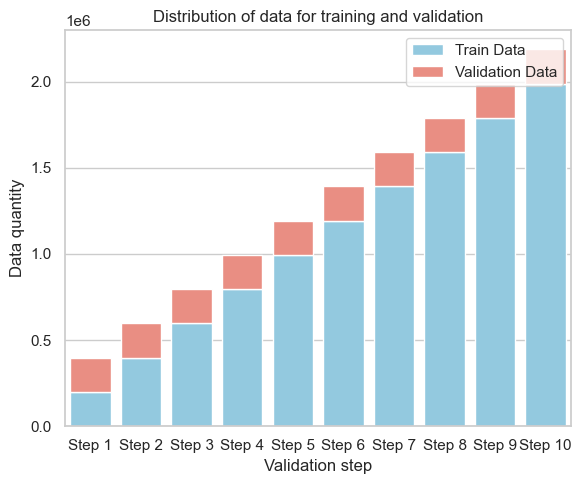

CPU times: total: 1.45 s
Wall time: 1.63 s


In [5]:
%%time
test_validation_class = Validation(
                 train_data=data['train_data'],
                 submission_data=data['submission_data'],
                 submission_example=data['submission_example'],
                 n_splits=10,
                 model = RandomForestRegressor(max_depth=1, n_estimators=1, random_state=42, n_jobs=-1),
                 check_nans=True,
                 dropna = True,
                 validation_schema_plot=True
                )

In [6]:
%%time
test_validation_class.validate()

CPU times: total: 10.9 s
Wall time: 11.4 s


RMSE  MAE                MAPE  sMAPE    R2
Steps  Train/Validation/Test                                           
step1  train                 0.97 0.44  966846709652328.00 189.09  0.22
       validation            1.11 0.47  948281475226063.88 188.37  0.15
step2  train                 0.98 0.44  925439528006760.62 188.49  0.23
       validation            9.24 0.46  920393271378152.62 188.98  0.08
step3  train                 2.33 0.49 1080693376073084.38 187.86  0.44
       validation            6.06 0.51 1075059490980861.50 187.44  0.50
step4  train                 3.12 0.50 1097590537238240.75 187.59  0.49
       validation            6.29 0.53 1098842741612959.25 187.79  0.53
step5  train                 3.77 0.51 1127545079864307.75 187.37  0.51
       validation            3.53 0.51 1128960471517496.25 187.47  0.49
step6  train                 3.34 0.50 1101994391501789.75 187.60  0.55
       validation            5.30 0.63 1063393936589067.25 186.29  0.64
step7  train                 3.62 0.53 1169667017149152.25 186.76  0.58
       validation            4.85 0.57 1169891392345867.25 186.63  0.34
step8  train                 3.83 0.53 1159013015037865.50 186.83  0.54
       validation            5.69 0.53 1186924131044575.75 187.58 -0.01
step9  train                 4.04 0.53 1155390532064113.50 186.97  0.50
       validation            4.53 0.49 1173957224314716.75 187.85  0.46
step10 train                 3.98 0.53 1158975408036444.00 187.05  0.51
       validation            5.88 0.52 1170245710469774.50 187.62  0.50

In [7]:
test_validation_class.predict_test()

,Test metrics
RMSE,5.25
MAE,0.50
MAPE,1165914671974308.25
sMAPE,187.93
R2,0.51


In [8]:
%%time
test_validation_class.predict_submission()

CPU times: total: 1.77 s
Wall time: 1.83 s


,ID,item_cnt_month
0,0,0.30
1,1,0.00
2,2,0.00
3,3,0.00
4,4,0.00
...,...,...
214195,214195,0.00
214196,214196,0.00
214197,214197,0.30
214198,214198,0.00


### Learn models

##### Random Forest Regressor

In [9]:
%%time
random_forest_regression = Validation(
                                 train_data=data['train_data'],
                                 submission_data=data['submission_data'],
                                 submission_example=data['submission_example'],
                                 n_splits=10,
                                 model = RandomForestRegressor(max_depth=5, n_estimators=15, random_state=42, n_jobs=-1),
                                 check_nans=True,
                                 dropna = True
                           )

Data is not sorted by time (5616 rows), it will be further sorted automatically
CPU times: total: 1.12 s
Wall time: 1.14 s


In [10]:
%%time
random_forest_report = random_forest_regression.validate()
random_forest_report

CPU times: total: 17min 35s
Wall time: 2min 6s


RMSE  MAE               MAPE  sMAPE   R2
Steps  Train/Validation/Test                                         
step1  train                 0.46 0.31 632536295412764.00 184.82 0.63
       validation            0.65 0.34 664646025288423.50 182.97 0.51
step2  train                 0.52 0.32 648622520548903.38 183.77 0.59
       validation            4.63 0.33 588768532453430.12 185.82 0.54
step3  train                 0.61 0.34 685214955611738.75 185.19 0.85
       validation            1.86 0.34 610116739510287.38 186.04 0.84
step4  train                 0.71 0.35 702965333640339.62 185.23 0.88
       validation            1.57 0.36 664263983968075.00 186.02 0.88
step5  train                 0.77 0.35 708663102081721.75 185.33 0.90
       validation            0.94 0.35 687693023771908.88 185.54 0.87
step6  train                 0.77 0.35 707176236724366.38 185.86 0.90
       validation            2.56 0.45 657302325360796.50 184.15 0.83
step7  train                 0.91 0.36 726369817209983.88 184.74 0.89
       validation            4.21 0.43 848333364876378.00 182.55 0.43
step8  train                 1.01 0.37 722213766953422.00 184.42 0.88
       validation            4.09 0.38 788561983963580.88 184.69 0.27
step9  train                 1.15 0.38 763847132851832.88 185.45 0.86
       validation            1.43 0.35 733993299201023.38 187.56 0.83
step10 train                 1.10 0.38 778796997046435.62 185.86 0.86
       validation            0.98 0.36 772573851672095.75 186.78 0.92

In [11]:
random_forest_regression.predict_test()

,Test metrics
RMSE,0.88
MAE,0.36
MAPE,783123297330281.75
sMAPE,187.82
R2,0.92


In [12]:
%%time
RandomForest_regression_submission = random_forest_regression.predict_submission()

CPU times: total: 4min 7s
Wall time: 27.8 s


##### XGboost

In [13]:
%%time
XGB_regression = Validation(
                     train_data=data['train_data'],
                     submission_data=data['submission_data'],
                     submission_example=data['submission_example'],
                     n_splits=10,
                     model = XGBRegressor(n_estimators=10),
                     check_nans=False,
                     dropna = False
                 ) 

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 2.48 s
Wall time: 2.55 s


[0]	validation_0-rmse:1.73497	validation_1-rmse:1.85452
[9]	validation_0-rmse:1.50494	validation_1-rmse:1.95835
[0]	validation_0-rmse:1.70097	validation_1-rmse:1.82917
[9]	validation_0-rmse:1.41012	validation_1-rmse:1.44891
[0]	validation_0-rmse:1.74945	validation_1-rmse:2.25408
[9]	validation_0-rmse:1.36598	validation_1-rmse:1.74597
[0]	validation_0-rmse:1.87563	validation_1-rmse:1.98532
[9]	validation_0-rmse:1.42899	validation_1-rmse:1.53379
[0]	validation_0-rmse:1.90081	validation_1-rmse:1.77255
[9]	validation_0-rmse:1.42105	validation_1-rmse:1.37859
[0]	validation_0-rmse:1.88269	validation_1-rmse:1.74343
[9]	validation_0-rmse:1.39055	validation_1-rmse:1.14755
[0]	validation_0-rmse:1.86637	validation_1-rmse:2.13985
[9]	validation_0-rmse:1.37330	validation_1-rmse:1.52826
[0]	validation_0-rmse:1.89141	validation_1-rmse:2.22363
[9]	validation_0-rmse:1.38146	validation_1-rmse:1.66479
[0]	validation_0-rmse:1.92699	validation_1-rmse:1.69338
[9]	validation_0-rmse:1.39244	validation_1-rmse:

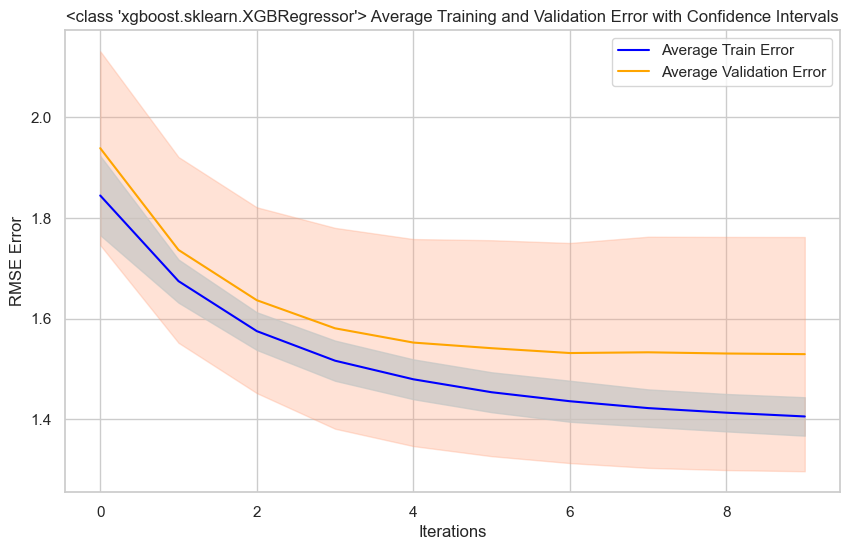

CPU times: total: 15min 4s
Wall time: 4min 56s


RMSE  MAE                MAPE  sMAPE    R2
Steps  Train/Validation/Test                                           
step1  train                 2.26 0.47  975882557796667.62 183.58  0.32
       validation            3.84 0.50 1352790791180837.00 185.73 -0.01
step2  train                 1.99 0.41  857349742342053.50 184.91  0.44
       validation            2.10 0.36  644595347355886.12 186.53  0.56
step3  train                 1.87 0.40  815164594858948.50 185.03  0.53
       validation            3.05 0.39  724157683732557.38 185.91  0.56
step4  train                 2.04 0.40  810089064197260.12 185.26  0.57
       validation            2.35 0.42  791674352510756.62 184.05  0.59
step5  train                 2.02 0.40  793192889756139.50 184.79  0.59
       validation            1.90 0.37  787159100465540.38 184.97  0.60
step6  train                 1.93 0.39  777014777351010.25 185.15  0.60
       validation            1.32 0.32  632574539572750.00 186.58  0.71
step7  train                 1.89 0.38  752516702947362.75 185.22  0.61
       validation            2.34 0.35  677154488224162.00 186.63  0.63
step8  train                 1.91 0.37  737400356840810.62 185.37  0.62
       validation            2.77 0.42  733530856864488.88 184.08  0.60
step9  train                 1.94 0.38  744972126363827.75 185.18  0.63
       validation            2.79 0.36  743330189686495.00 185.46  0.32
step10 train                 1.93 0.37  731323355184960.00 185.16  0.62
       validation            1.48 0.33  646841400135624.50 186.12  0.69

In [26]:
%%time
XGB_report = XGB_regression.validate()
XGB_report

In [15]:
XGB_regression.predict_test()

,Test metrics
RMSE,1.51
MAE,0.34
MAPE,661553061194067.75
sMAPE,187.95
R2,0.69


In [16]:
%%time
XGB_regression_submission = XGB_regression.predict_submission()

CPU times: total: 2min 44s
Wall time: 23.4 s


##### LightGBM

In [17]:
%%time

params = {
    "objective": "regression",  
    "metric": "rmse"            
}

LightGBM_regression = Validation(
                     train_data=data['train_data'],
                     submission_data=data['submission_data'],
                     submission_example=data['submission_example'],
                     n_splits=10,
                     model = lgb.LGBMRegressor(n_estimators=30, verbose_eval = -1),
                     params=params,
                     check_nans=False,
                     dropna = False
                 ) 

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 4.78 s
Wall time: 5.28 s


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1894
[LightGBM] [Info] Number of data points in the train set: 969608, number of used features: 26
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Start training from score 0.371501
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tru

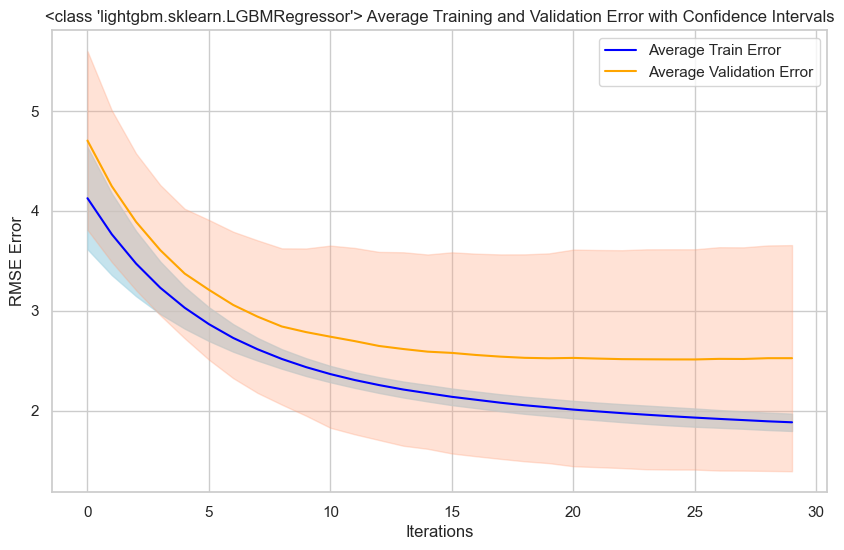

CPU times: total: 7min 44s
Wall time: 1min 53s


RMSE  MAE                MAPE  sMAPE    R2
Steps  Train/Validation/Test                                           
step1  train                 2.08 0.47  980729742758102.38 183.87  0.38
       validation            5.47 0.55 1593758169287577.00 185.68 -0.44
step2  train                 1.83 0.41  850801168263272.62 185.09  0.49
       validation            2.84 0.37  709515787209977.38 186.80  0.41
step3  train                 1.78 0.40  816321334331194.25 185.22  0.55
       validation            2.99 0.40  775156133299120.00 185.90  0.56
step4  train                 1.95 0.40  807341868237381.38 185.45  0.59
       validation            2.33 0.42  773417340120155.62 184.55  0.59
step5  train                 1.96 0.40  809097937456215.00 185.11  0.60
       validation            1.65 0.37  785393137055273.88 185.65  0.65
step6  train                 1.88 0.39  791628918876473.00 185.35  0.61
       validation            1.19 0.33  678009738552313.62 186.80  0.74
step7  train                 1.79 0.38  766739017932400.50 185.50  0.63
       validation            2.41 0.36  700060969495221.50 186.93  0.62
step8  train                 1.81 0.38  754565916799119.75 185.66  0.64
       validation            2.47 0.42  768730671105476.62 184.30  0.64
step9  train                 1.86 0.38  763416569757572.88 185.41  0.64
       validation            2.48 0.36  773598414952147.38 185.60  0.40
step10 train                 1.87 0.38  761430087904876.00 185.47  0.64
       validation            1.41 0.34  691368900055679.88 186.52  0.71

In [18]:
%%time
LightGBM_report = LightGBM_regression.validate()
LightGBM_report

In [19]:
LightGBM_regression.predict_test()

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.630548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3676
[LightGBM] [Info] Number of data points in the train set: 10665588, number of used features: 32
[LightGBM] [Info] Start training from score 0.323958
[LightGBM] [Warning] Unknown parameter: verbose_eval


,Test metrics
RMSE,1.44
MAE,0.35
MAPE,726299195538109.12
sMAPE,188.18
R2,0.70


In [20]:
%%time
LightGBM_regression_submission = LightGBM_regression.predict_submission()

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.474742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3674
[LightGBM] [Info] Number of data points in the train set: 10902924, number of used features: 32
[LightGBM] [Info] Start training from score 0.322979
[LightGBM] [Warning] Unknown parameter: verbose_eval
CPU times: total: 1min 7s
Wall time: 15.7 s


##### Catboost

In [21]:
%%time
catboost_regression = Validation(
                 train_data=data['train_data'],
                 submission_data=data['submission_data'],
                 submission_example=data['submission_example'],
                 n_splits=10,
                 model = cb.CatBoostRegressor(iterations=10, verbose=100),
                 check_nans=False,
                 dropna = False
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 3.48 s
Wall time: 4.99 s


Learning rate set to 0.5
0:	learn: 1.7256304	test: 1.7902728	best: 1.7902728 (0)	total: 216ms	remaining: 1.95s
9:	learn: 1.5661450	test: 1.8474656	best: 1.7212172 (3)	total: 743ms	remaining: 0us

bestTest = 1.721217222
bestIteration = 3

Shrink model to first 4 iterations.
Learning rate set to 0.5
0:	learn: 1.6874902	test: 1.7165170	best: 1.7165170 (0)	total: 97.2ms	remaining: 875ms
9:	learn: 1.4613701	test: 1.5198789	best: 1.5120387 (2)	total: 1.1s	remaining: 0us

bestTest = 1.512038676
bestIteration = 2

Shrink model to first 3 iterations.
Learning rate set to 0.5
0:	learn: 1.6876848	test: 2.0755771	best: 2.0755771 (0)	total: 130ms	remaining: 1.17s
9:	learn: 1.3979211	test: 1.7310468	best: 1.7305056 (8)	total: 1.48s	remaining: 0us

bestTest = 1.730505638
bestIteration = 8

Shrink model to first 9 iterations.
Learning rate set to 0.5
0:	learn: 1.7871550	test: 1.8527473	best: 1.8527473 (0)	total: 161ms	remaining: 1.45s
9:	learn: 1.4586674	test: 1.5358165	best: 1.5340968 (7)	total: 1.88

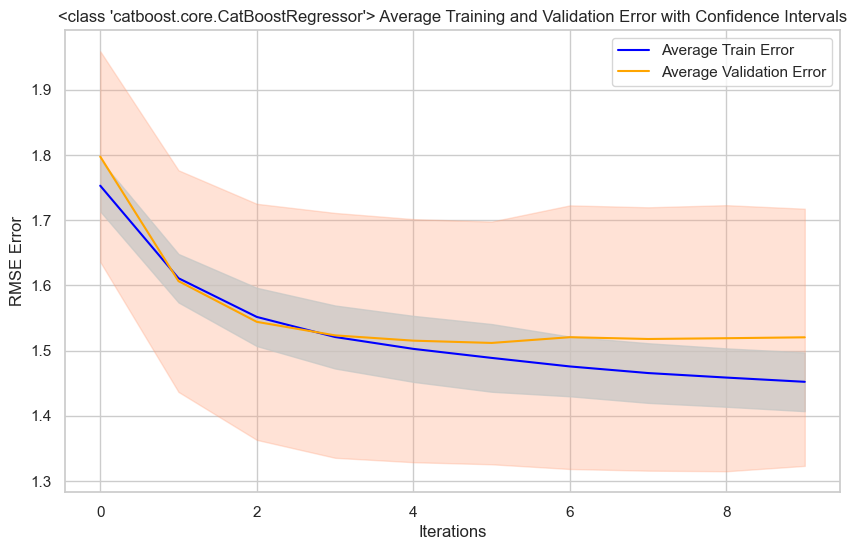

CPU times: total: 3min 55s
Wall time: 1min 1s


RMSE  MAE                MAPE  sMAPE   R2
Steps  Train/Validation/Test                                          
step1  train                 2.68 0.52 1091286746173604.88 184.78 0.20
       validation            2.96 0.48 1243506413812303.25 186.06 0.22
step2  train                 2.41 0.47  990302164371911.00 186.20 0.33
       validation            2.29 0.43  918169365444162.25 187.44 0.53
step3  train                 1.96 0.41  821426713318547.62 185.62 0.51
       validation            2.99 0.40  780964723706131.25 186.05 0.56
step4  train                 2.17 0.41  815367337223226.12 186.09 0.54
       validation            2.35 0.42  725569974051713.50 185.76 0.59
step5  train                 2.36 0.43  887863030127389.25 186.41 0.52
       validation            1.73 0.40  836159942481209.50 186.99 0.64
step6  train                 2.18 0.40  802354713348986.75 185.86 0.55
       validation            1.37 0.34  695388047850972.38 186.90 0.70
step7  train                 1.99 0.39  763205341417851.00 185.95 0.59
       validation            2.28 0.36  711856172135764.75 187.22 0.64
step8  train                 2.04 0.38  733915030297501.88 186.02 0.59
       validation            2.74 0.41  684656012636513.38 185.16 0.60
step9  train                 2.35 0.43  895726967088488.88 186.75 0.55
       validation            2.52 0.41  929590813206730.12 186.90 0.39
step10 train                 2.08 0.38  744265288158226.75 185.83 0.59
       validation            1.56 0.35  752941141039873.25 186.15 0.68

In [22]:
%%time
CatBoost_report = catboost_regression.validate()
CatBoost_report

In [23]:
catboost_regression.predict_test()

Learning rate set to 0.5
0:	learn: 1.7692555	total: 575ms	remaining: 5.18s
9:	learn: 1.4190846	total: 5.26s	remaining: 0us


,Test metrics
RMSE,1.43
MAE,0.36
MAPE,757176267312364.75
sMAPE,188.09
R2,0.70


In [24]:
CatBoost_regression_submission = catboost_regression.predict_submission()

Learning rate set to 0.5
0:	learn: 1.7723878	total: 402ms	remaining: 3.62s
9:	learn: 1.4172367	total: 4.93s	remaining: 0us


### Сomparison of models based on validation results

In [27]:
n_steps = 10

scores = pd.MultiIndex.from_product([["step" + str(i) for i in range(1, n_steps+1)],
                                  ['train', 'validation']],
                                 names=['Steps', 'RMSE'])
models = ['RandomForest', 'XGB', 'LightGBM', 'CatBoost']
df = pd.DataFrame('-', scores, models)

steps =  ["step" + str(i) for i in range(1, n_steps+1)]
reports = {'RandomForest': random_forest_report,
           'XGB':XGB_report,
           'LightGBM':LightGBM_report,
           'CatBoost':CatBoost_report
          }

for model, report in reports.items():
    df.loc[:, model] = report.RMSE
df

RandomForest  XGB LightGBM CatBoost
Steps  RMSE                                          
step1  train              0.46 2.26     2.08     2.68
       validation         0.65 3.84     5.47     2.96
step2  train              0.52 1.99     1.83     2.41
       validation         4.63 2.10     2.84     2.29
step3  train              0.61 1.87     1.78     1.96
       validation         1.86 3.05     2.99     2.99
step4  train              0.71 2.04     1.95     2.17
       validation         1.57 2.35     2.33     2.35
step5  train              0.77 2.02     1.96     2.36
       validation         0.94 1.90     1.65     1.73
step6  train              0.77 1.93     1.88     2.18
       validation         2.56 1.32     1.19     1.37
step7  train              0.91 1.89     1.79     1.99
       validation         4.21 2.34     2.41     2.28
step8  train              1.01 1.91     1.81     2.04
       validation         4.09 2.77     2.47     2.74
step9  train              1.15 1.94     1.86     2.35
       validation         1.43 2.79     2.48     2.52
step10 train              1.10 1.93     1.87     2.08
       validation         0.98 1.48     1.41     1.56

### Learning curve for models

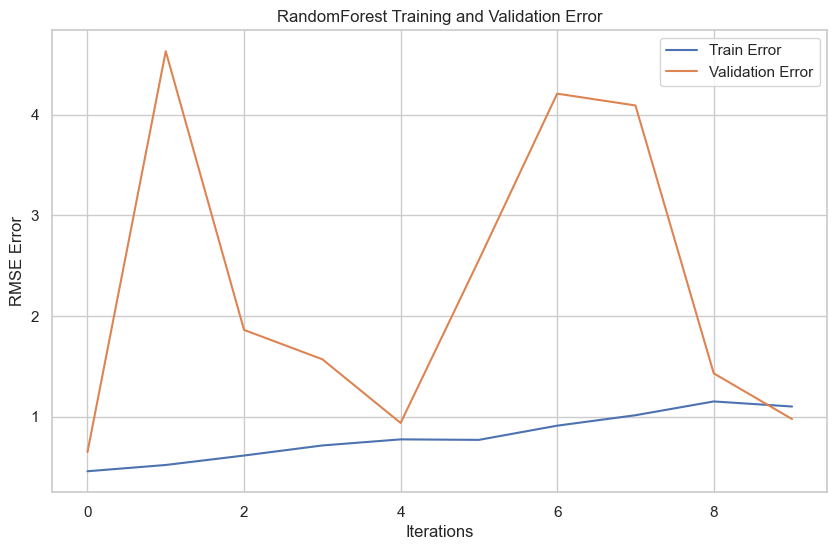

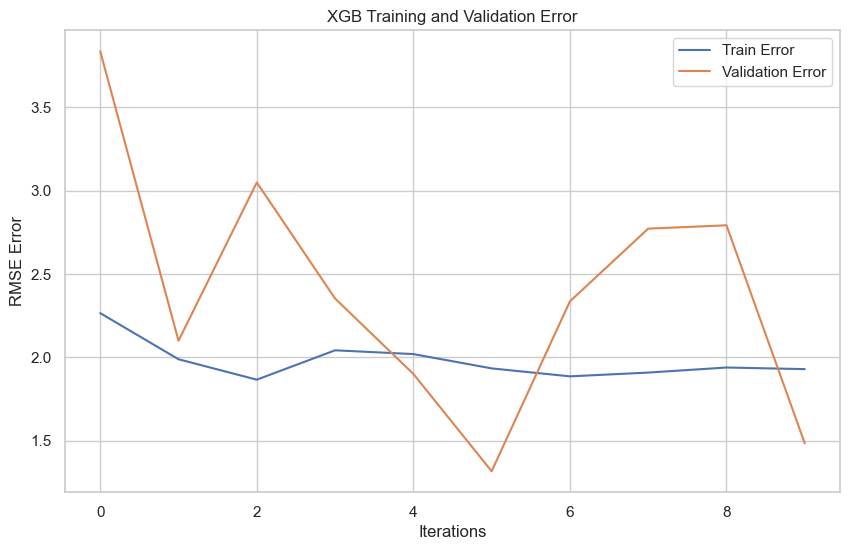

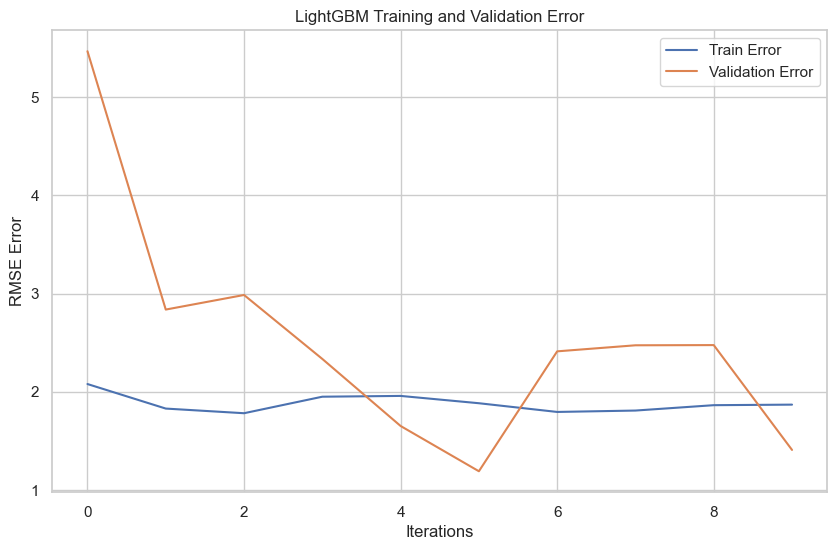

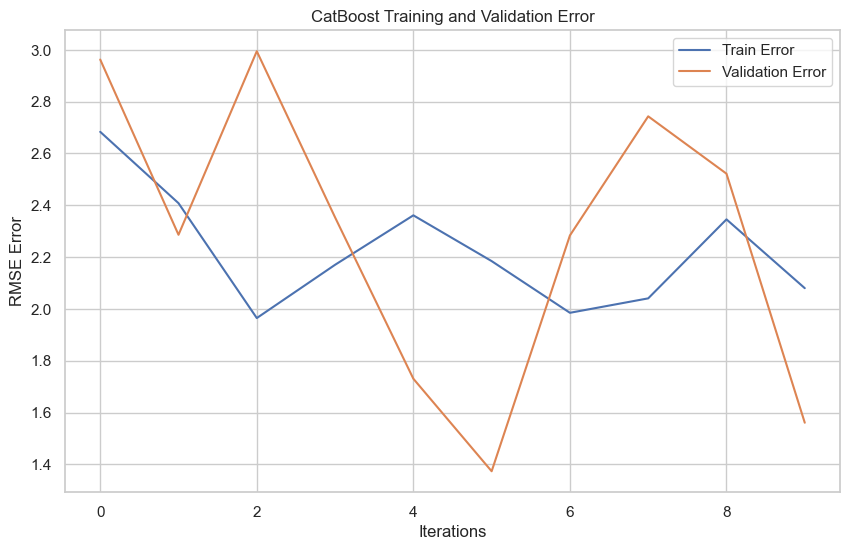

In [28]:
for model in df.columns:
    temp = df[model].reset_index()
    train_error = temp[temp.RMSE=='train'].iloc[:, 2].values
    val_error = temp[temp.RMSE=='validation'].iloc[:, 2].values

    plt.figure(figsize=(10, 6))
    plt.plot(train_error, label='Train Error')
    plt.plot(val_error, label='Validation Error')
    plt.xlabel('Iterations')
    plt.ylabel('RMSE Error')
    plt.legend()
    plt.title(f'{model} Training and Validation Error')
    plt.show()

### Save submission results

In [29]:
submission_data = {
    'RF_submission' : RandomForest_regression_submission,
    'XGB_submission' : XGB_regression_submission,
    'LightGBM_submission' : LightGBM_regression_submission,
    'CatBoost_submission' : CatBoost_regression_submission
}

In [30]:
%%time
# get directory path
dirpath = os.getcwd()

# add path to load 
path_to_load = Path(dirpath) / 'data' / 'baseline_submissions'
os.makedirs(path_to_load, exist_ok=True)

# write data
for filename, df in submission_data.items():
    filepath = path_to_load / (filename + ".csv")
    with open(filepath, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(df)

CPU times: total: 0 ns
Wall time: 11.2 ms


In [31]:
from os import listdir
from os.path import isfile, join
print(*[f+"\n" for f in listdir(path_to_load) if isfile(join(path_to_load, f))])

CatBoost_submission.csv
 LightGBM_submission.csv
 RF_submission.csv
 XGB_submission.csv



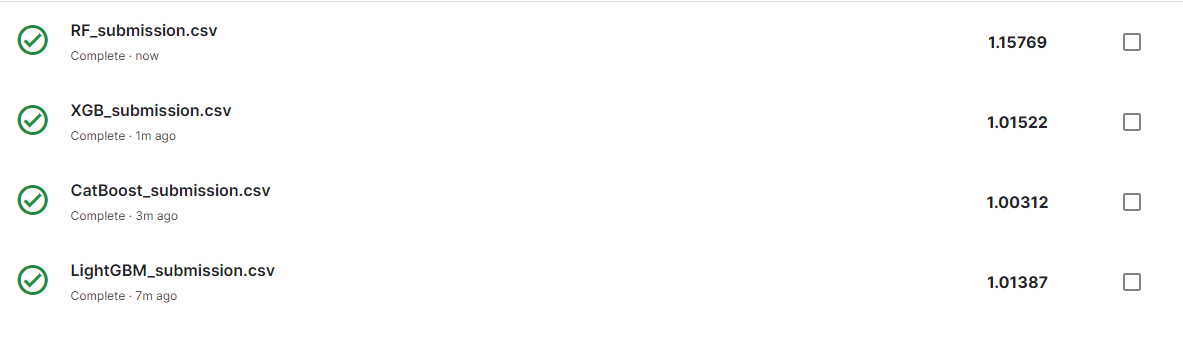